# LSTM 1

- SentimentText를 X로, Aspect를 y로 학습시킨 모델(Input_length=26)
- SentimentText, RawText로 테스트: 정확도 94.96%, 24.67% 
<br>  (원인: 텍스트 길이가 다름 - SentimentText 평균 5 최대 26, RawText 평균 27 최대 159)
- SentimentText 학습모델의 Input_length를 42로 늘려서 재확인
- SentimentText, RawText로 테스트 : 정확도 SentimentText: 43.87%, RawText: 23.38%

## Set

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import platform
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Load Data

### cosmetics

In [2]:
path = "../../data/raw/"
df_cosmetics = pd.read_csv(path+"cosmetics.csv", sep = ',', encoding = 'utf-8', header = 0)
df_cosmetics.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,기능/효과,올 겨울은 촉촉하게 보내고 있어 좋습니다.,6,1
1,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,보습력/수분감/쿨링감,촉촉하게,1,1
2,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,용기,"케이스는 이쁜데,",2,1
3,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,용량/개수,양이 적어서,2,-1
4,660038,발림성 좋습니다. 지속력 좋네요. 건조해진 입술 살짝 발라줬는데 금방 촉촉해져서 좋...,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,86,20,20171121,1.0,발림성,발림성 좋습니다.,2,1


In [3]:
df_cosmetics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150318 entries, 0 to 150317
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              150318 non-null  int64  
 1   RawText            150318 non-null  object 
 2   Source             150318 non-null  object 
 3   Domain             150318 non-null  object 
 4   MainCategory       150318 non-null  object 
 5   ProductName        150316 non-null  object 
 6   ReviewScore        150318 non-null  int64  
 7   Syllable           150318 non-null  int64  
 8   Word               150318 non-null  int64  
 9   RDate              150318 non-null  int64  
 10  GeneralPolarity    148644 non-null  float64
 11  Aspect             150318 non-null  object 
 12  SentimentText      150318 non-null  object 
 13  SentimentWord      150318 non-null  int64  
 14  SentimentPolarity  150318 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 17

In [4]:
df_cosmetics['Aspect'].nunique()

44

In [5]:
df_cosmetics['Aspect'].unique()

array(['기능/효과', '보습력/수분감/쿨링감', '용기', '용량/개수', '발림성', '지속력/유지력', '흡수력',
       '향', '편의성/활용성', '발색력', '가격', '제품구성', '자극성', '윤기/피부(톤)', '디자인',
       '품질', '유통기한', '밀착력/접착력', '색상', '제형', '사이즈/두께', '용량', '보습력/수분감',
       '사용감', '피부타입', '성분', '지속력', '탄력', '커버력', '머릿결관리', '염색력', '이염',
       '용량/사이즈', '향/냄새', '스타일링효과', '클렌징/제거력', '세팅력/고정력', '청량감/쿨링감',
       '두피보호', '탈모개선', '세정력', '거품력', '분사력', '그립감'], dtype=object)

In [6]:
df_cosmetics['Aspect'].value_counts()

기능/효과          16934
가격             13196
보습력/수분감        11269
향              10377
편의성/활용성         9422
흡수력             8848
발림성             6656
향/냄새            5947
지속력/유지력         5453
제품구성            5310
윤기/피부(톤)        4927
자극성             4719
보습력/수분감/쿨링감     4222
색상              3421
제형              3341
머릿결관리           3089
발색력             2833
용기              2443
염색력             2363
용량              2287
커버력             1985
품질              1943
피부타입            1803
밀착력/접착력         1677
유통기한            1651
용량/사이즈          1564
사용감             1115
성분              1052
청량감/쿨링감         1049
탈모개선            1010
스타일링효과           976
용량/개수            959
세정력              909
세팅력/고정력          904
지속력              895
탄력               870
사이즈/두께           720
거품력              687
디자인              485
이염               347
클렌징/제거력          304
두피보호             249
분사력              100
그립감                7
Name: Aspect, dtype: int64

### garments

In [7]:
df_garments = pd.read_csv(path+"garments.csv", sep = ',', encoding = 'utf-8', header = 0)
df_garments.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,128481,아들에게 선물했는데 불편하고 활동하기 안좋다고 잘 안입고 다니네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,37,8,20180626,-1.0,착용감,불편하고,1,-1
1,128481,아들에게 선물했는데 불편하고 활동하기 안좋다고 잘 안입고 다니네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,37,8,20180626,-1.0,착용감,활동하기 안좋다고 잘 안입고 다니네요,5,-1
2,128483,울아들이입어보고너무불편하다고상품이별로래요. 불편해서자주입을것같지는 않데요.,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,41,3,20180321,-1.0,착용감,너무불편하다고상품이별로래요.,1,-1
3,128483,울아들이입어보고너무불편하다고상품이별로래요. 불편해서자주입을것같지는 않데요.,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,41,3,20180321,-1.0,착용감,불편해서자주입을것같지는 않데요.,2,-1
4,128484,이번에구매한데님은사이즈가잘맞네요 색상구성도괜찮고맘에든답니다 잘입겠습니다,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,39,3,20180315,1.0,사이즈,사이즈가잘맞네요,1,1


In [8]:
df_garments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152143 entries, 0 to 152142
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              152143 non-null  int64  
 1   RawText            152143 non-null  object 
 2   Source             152143 non-null  object 
 3   Domain             152143 non-null  object 
 4   MainCategory       152143 non-null  object 
 5   ProductName        152125 non-null  object 
 6   ReviewScore        152143 non-null  int64  
 7   Syllable           152143 non-null  int64  
 8   Word               152143 non-null  int64  
 9   RDate              152143 non-null  int64  
 10  GeneralPolarity    149774 non-null  float64
 11  Aspect             152143 non-null  object 
 12  SentimentText      152143 non-null  object 
 13  SentimentWord      152143 non-null  int64  
 14  SentimentPolarity  152143 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 17

In [9]:
df_garments['Aspect'].nunique()

27

In [10]:
df_garments['Aspect'].unique()

array(['착용감', '사이즈', '색상', '핏', '신축성', '마감', '가격', '디자인', '품질', '제품구성',
       '두께', '기능', '무게', '길이', '소재', '활용성', '촉감', '냄새', '사용성/편의성', '내구성',
       '기능성', '사이즈/폭/길이/두께', '수납', '치수/사이즈', '착화감', '사용성', '굽'],
      dtype=object)

In [11]:
df_garments['Aspect'].value_counts()

디자인            16353
사이즈            14163
가격             13616
품질             11799
착화감            10667
기능             10492
소재             10312
색상              8965
착용감             8154
치수/사이즈          5985
무게              5664
핏               5621
길이              4305
신축성             4228
두께              3924
활용성             3368
촉감              2499
제품구성            1811
기능성             1810
사이즈/폭/길이/두께     1712
사용성             1545
마감              1517
사용성/편의성         1154
내구성             1016
굽                674
냄새               524
수납               265
Name: Aspect, dtype: int64

### home_appliances

In [12]:
df_home_appliances = pd.read_csv(path+"home_appliances.csv", sep = ',', encoding = 'utf-8', header = 0)
df_home_appliances.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,5215,일주일째 쓰고 있는데 진동은 강한데 이물질은 잘 빠지지 않아서 그닥. 칫솔모도 너무...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,61,15,20200514,0.0,기능,진동은 강한데 이물질은 잘 빠지지 않아서 그닥,7,0
1,5215,일주일째 쓰고 있는데 진동은 강한데 이물질은 잘 빠지지 않아서 그닥. 칫솔모도 너무...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,61,15,20200514,0.0,사이즈,칫솔모도 너무 작아서 저한테는 별로예요,5,-1
2,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,기능,일주일째 쓰고 있는데 진동은 강합니다.,5,1
3,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,조작성,이물질은 빠지지는 않네요.,3,-1
4,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,편의성,칫솔질 하는 것보단 편하김 해요,5,1


In [13]:
df_home_appliances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111730 entries, 0 to 111729
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              111730 non-null  int64  
 1   RawText            111730 non-null  object 
 2   Source             111730 non-null  object 
 3   Domain             111730 non-null  object 
 4   MainCategory       111730 non-null  object 
 5   ProductName        111730 non-null  object 
 6   ReviewScore        111730 non-null  int64  
 7   Syllable           111730 non-null  int64  
 8   Word               111730 non-null  int64  
 9   RDate              111730 non-null  int64  
 10  GeneralPolarity    90018 non-null   float64
 11  Aspect             111730 non-null  object 
 12  SentimentText      111730 non-null  object 
 13  SentimentWord      111730 non-null  int64  
 14  SentimentPolarity  111730 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 12

In [14]:
df_home_appliances['Aspect'].nunique()

20

In [15]:
df_home_appliances['Aspect'].unique()

array(['기능', '사이즈', '조작성', '편의성', '품질', '가격', '디자인', '용량', '제품구성', '소음',
       '내구성', '무게', '배터리', '제조일/제조사', '시간/속도', '소재', '색상', '소비전력',
       '음량/음질', '화질'], dtype=object)

In [16]:
df_home_appliances['Aspect'].value_counts()

기능         26480
가격         12004
편의성         9980
디자인         9614
소음          8799
품질          6290
조작성         5332
사이즈         5305
색상          4305
음량/음질       3966
용량          3360
무게          3003
제품구성        2832
제조일/제조사     2612
화질          2047
시간/속도       1731
소비전력        1199
내구성         1143
소재          1051
배터리          677
Name: Aspect, dtype: int64

### tech_devices

In [17]:
df_tech_devices = pd.read_csv(path+"tech_devices.csv", sep = ',', encoding = 'utf-8', header = 0)
df_home_appliances.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,5215,일주일째 쓰고 있는데 진동은 강한데 이물질은 잘 빠지지 않아서 그닥. 칫솔모도 너무...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,61,15,20200514,0.0,기능,진동은 강한데 이물질은 잘 빠지지 않아서 그닥,7,0
1,5215,일주일째 쓰고 있는데 진동은 강한데 이물질은 잘 빠지지 않아서 그닥. 칫솔모도 너무...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,61,15,20200514,0.0,사이즈,칫솔모도 너무 작아서 저한테는 별로예요,5,-1
2,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,기능,일주일째 쓰고 있는데 진동은 강합니다.,5,1
3,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,조작성,이물질은 빠지지는 않네요.,3,-1
4,5216,일주일째 쓰고 있는데 진동은 강합니다. 이물질은 빠지지는 않네요. 칫솔질 하는 것...,SNS,가전,생활/미용/욕실가전,(방송중2만원할인) 필립스 프로텍티브 클린 1.0 더블핸들 (HX6456/03),70,55,13,20200514,1.0,편의성,칫솔질 하는 것보단 편하김 해요,5,1


In [18]:
df_tech_devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100823 entries, 0 to 100822
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              100823 non-null  int64  
 1   RawText            100823 non-null  object 
 2   Source             100823 non-null  object 
 3   Domain             100823 non-null  object 
 4   MainCategory       100823 non-null  object 
 5   ProductName        100823 non-null  object 
 6   ReviewScore        100823 non-null  int64  
 7   Syllable           100823 non-null  int64  
 8   Word               100823 non-null  int64  
 9   RDate              100823 non-null  int64  
 10  GeneralPolarity    88027 non-null   float64
 11  Aspect             100823 non-null  object 
 12  SentimentText      100823 non-null  object 
 13  SentimentWord      100823 non-null  int64  
 14  SentimentPolarity  100823 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 11

In [19]:
df_tech_devices['Aspect'].nunique()

20

In [20]:
df_tech_devices['Aspect'].unique()

array(['사이즈', '기능', '가격', '시간/속도', '편의성', '품질', '제품구성', '무게', '용량', '화질',
       '색상', '디자인', '배터리', '제조일/제조사', '조작성', '음량/음질', '내구성', '소재', '소음',
       '소비전력'], dtype=object)

In [21]:
df_tech_devices['Aspect'].value_counts()

가격         13919
기능         11687
편의성         7774
사이즈         7205
조작성         7019
품질          6714
음량/음질       6596
디자인         6142
색상          5495
화질          4817
제품구성        4621
무게          4241
제조일/제조사     3594
시간/속도       3414
배터리         2094
소음          1793
내구성         1602
용량          1156
소재           893
소비전력          47
Name: Aspect, dtype: int64

## Categorizing

### cosmetics

In [22]:
# categories = {
#     "price": ["가격"],
#     "composition": ["제품구성", "성분"],
#     "usability": ["거품력", "발림성", "분사력", "사용감", "세정력", "자극성", "제형", "클렌징/제거력"],
#     "packaging": ["그립감", "디자인", "사이즈/두께", "색상", "용기", "용량", "용량/개수", "용량/사이즈", "유통기한", "편의성/활용성"],
#     "quality": ["밀착력/접착력", "발색력", "보습력/수분감", "보습력/수분감/쿨링감", "이염", "품질", "향", "향/냄새", "흡수력"],
#     "effectiveness": ["기능/효과", "세팅력/고정력", "염색력", "지속력", "지속력/유지력", "청량감/쿨링감", "커버력", "두피보호", "머릿결관리", "스타일링효과", "윤기/피부(톤)", "탄력", "탈모개선", "피부타입"]
# }


### garments

In [23]:
# categories = {
#     "size": ["사이즈", "핏", "두께", "길이", "사이즈/폭/길이/두께", "치수/사이즈", "굽"],
#     "design": ["색상", "디자인"],
#     "quality": ["마감", "품질", "소재", "촉감", "냄새", "내구성"],
#     "usability": ["사용성/편의성", "사용성", "수납", "활용성", "제품구성", "무게", "신축성", "기능", "기능성", "착화감", "착용감"],
#     "price": ["가격"]
# }

### home_appliances

In [24]:
# categories = {
#     "price": ["가격"],
#     "composition": ["제품구성"],
#     "design": ["디자인", "색상"],
#     "specification": ["무게", "배터리", "사이즈", "소비전력", "소재", "용량", "제조일/제조사"],
#     "performance": ["기능", "내구성", "소음", "시간/속도", "음량/음질", "품질", "화질"],
#     "usability": ["조작성", "편의성"]
# }

### tech_devices

In [25]:
# categories = {}

## Top5 Aspect 학습 (SentimentText to Aspect)

### 패션 garments

In [26]:
df_garments = df_garments.dropna()
df_garments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149756 entries, 0 to 152142
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              149756 non-null  int64  
 1   RawText            149756 non-null  object 
 2   Source             149756 non-null  object 
 3   Domain             149756 non-null  object 
 4   MainCategory       149756 non-null  object 
 5   ProductName        149756 non-null  object 
 6   ReviewScore        149756 non-null  int64  
 7   Syllable           149756 non-null  int64  
 8   Word               149756 non-null  int64  
 9   RDate              149756 non-null  int64  
 10  GeneralPolarity    149756 non-null  float64
 11  Aspect             149756 non-null  object 
 12  SentimentText      149756 non-null  object 
 13  SentimentWord      149756 non-null  int64  
 14  SentimentPolarity  149756 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 18

In [27]:
df_garments['Aspect'].value_counts()[:6]

디자인    16177
사이즈    13793
가격     13450
품질     11627
착화감    10602
기능     10280
Name: Aspect, dtype: int64

In [28]:
# 착화감은 신발에만 해당되므로, 제외하고 top5 기준으로 데이터 추출
targets = ["디자인", "사이즈", "가격", "품질", "기능"]
target_df = df_garments.loc[df_garments["Aspect"].isin(targets), :]
target_df.head(2)

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
4,128484,이번에구매한데님은사이즈가잘맞네요 색상구성도괜찮고맘에든답니다 잘입겠습니다,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,39,3,20180315,1.0,사이즈,사이즈가잘맞네요,1,1
15,128494,바지는 너무 편하고 좋은데 좀크게나온듯 그리고 허리고리 하나가 안달려서 밑단수선하면...,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,60,118,24,20180317,0.0,사이즈,좀크게나온듯,1,-1


In [29]:
label_encoder = LabelEncoder()
enc_data = label_encoder.fit_transform(target_df['Aspect'])
num_labels = len(set(enc_data))
num_labels

5

In [30]:
X, y = target_df.loc[:, "SentimentText"].to_list(), enc_data

In [31]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X, y, test_size=0.2, random_state=88)

In [32]:
X_train_S

['디자인은 괜찮아요',
 '따뜻해요',
 '베스트 퀄리티가 좋네요',
 '가격도 좋고 ',
 '세탁후에도 털빠짐 있고 ㅜ',
 '롱패딩치고 a라인이라 그런지 여성스럽네요',
 '지금계절에입기딱이네요',
 '부채꼴모양의 클러치가 모양은 제일 제 취향인데',
 '깃에있는 버클고리가 끊어져서 왔습니다.',
 '옷이 모양이 풍성해서',
 '디자인이 깔끔하고 ',
 '크게 입고싶어서 라지샀는데 엑스라지 살걸 그랬어요',
 '디자인과 색상이 좋아요',
 '95사이즈가 없어서 100으로 주문했는데 예쁘게 잘 맞아요 ',
 '32 주문했는데 약간 크게 나왔습니다.',
 '하사이즈 작게 사도 될 듯 해요~^^',
 '갈색이힙둘레가3센치정도작더라구요',
 '품질 매우 만족합니다.',
 '엄청커고',
 '가격이 싸니 ',
 '가격만큼은 입을수있겠지요.^^',
 '가격대비 좋은 상품인것 같아요.',
 '세장다 다 디자인이 예쁘고',
 '생각보다 시원하진 않네요',
 '디자인 무난하게 입을 수 있어 만족해요',
 '디자인도 좋고  ',
 '저렴하게 잘 구매했습니다 ',
 '넘 예쁘게 잘 신어요~~',
 '원래 입던대로 주문 했는데.. 사이즈 잘 맞습니다...',
 '모양도 예쁘고',
 '사이즈도 잘 맞아서 좋네요^^',
 '정사이즈로 사거나 반사이즈는 사이즈 올리는게 좋을듯 해요.',
 '한치수 업해서',
 '한가지 바닥이 미끄러워요',
 '디자인이 발볼 태평양인 제게 부끄러움을 덜어줬네요 ',
 ' 밴드처리 되어있어',
 '세련되게 보여 좋아요..',
 '가죽 가방을  이 가격에  3개나  득템하여서 정말 만족합니다~',
 '좋은가격에 만들어주셔서고맙습니다^^♡',
 '품질도 좋아서',
 '싼게 비지떡이란 말이 생각나고 후회를 많이 했습니다.',
 ' 싼 맛에  대충 입겠지만',
 '품이엄척크네요.',
 '지금보다는 쬠 따뜻해지면 입어야할듯요',
 '세일 많이 해서 구매 했는데',
 '두개도 입어봤는데 사이즈가 너무너무 커서 못입을 정도네요',
 '좀 타이트하게 나온듯요. ',


In [33]:
y_train_S

array([2, 1, 4, ..., 4, 2, 0])

#### Tokenization

In [34]:
# Tokenization
def preprocessing(rawtext,okt,stem=False,remove_stopwords=False,stopwords=[]):
    # 1. 한글 및 공백 제외한 문자 모두 제거 
    rawtext = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',rawtext)
    rawtext = re.sub(r"[^가-힣A-Za-z)-9(),!?\'\`]", " ", rawtext)
    # 2. Okt 객체를 활용하여 형태소 단어로 나눔 / 어간 추출 (선택)
    word_text = okt.morphs(rawtext,stem=False)

    if stem:
        word_text = okt.morphs(rawtext,stem=True)
        
        if remove_stopwords:
            # 3. 불용어 제거 (선택)
            word_text = [token for token in word_text if not token in stopwords]          
        return word_text
        
    return word_text

In [35]:
okt = Okt()
stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
# stopwords 근거 찾아보기
# stopwords = [‘의’,‘가’,‘이’,‘은’,‘들’,‘는’,‘좀’,‘잘’,‘걍’,‘과’,‘도’,‘를’,‘으로’,‘자’,‘에’,‘와’,‘한’,‘하다’,‘다’, ‘로’]

In [36]:
# preprocessing에서 가장 정확도가 높았던 Type 2 선택
clean_train_review_S = []
clean_test_review_S = []

for SentimentText in X_train_S:
    clean_train_review_S.append(preprocessing(SentimentText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))
    
for SentimentText in X_test_S:
    clean_test_review_S.append(preprocessing(SentimentText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))

clean_train_review_S[:4]

[['디자인', '은', '괜찮다'], ['따뜻하다'], ['베스트', '퀄리티', '가', '좋다'], ['가격', '도', '좋다']]

In [37]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_S = [len(tokens) for tokens in clean_train_review_S]
df_tokens_len_S = pd.DataFrame(tokens_len_S, columns=['Token Count'])
df_tokens_len_S.describe()

,Token Count
count,52261.000000
mean,5.253459
std,2.776958
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,26.000000


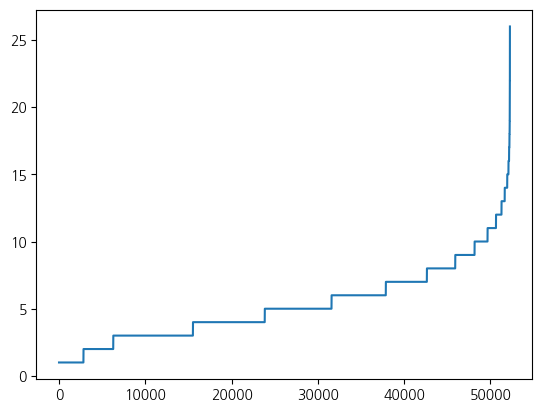

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline 

tokens_len_S.sort()
plt.plot(tokens_len_S)
plt.show()

In [39]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_S = [len(tokens) for tokens in clean_test_review_S]
df_tokens_len_S = pd.DataFrame(tokens_len_S, columns=['Token Count'])
df_tokens_len_S.describe()

,Token Count
count,13066.000000
mean,5.206796
std,2.762374
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,23.000000


In [40]:
max_sequence_length = 26
print(sum([int(l<=max_sequence_length) for l in tokens_len_S]))

13066


In [41]:
# 토큰 수 컨트롤
modified_clean_train_review_S = [tokens[:max_sequence_length] for tokens in clean_train_review_S]
modified_clean_test_review_S = [tokens[:max_sequence_length] for tokens in clean_test_review_S]

In [42]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_S)

X_train_S1 = tokenizer.texts_to_sequences(modified_clean_train_review_S)
X_train_S1 = pad_sequences(X_train_S1, maxlen=max_sequence_length, padding='post')

X_test_S1 = tokenizer.texts_to_sequences(modified_clean_test_review_S)
X_test_S1 = pad_sequences(X_test_S1, maxlen=max_sequence_length, padding ='post') 

print(X_train_S1[:5])

[[  6  12  42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [ 21   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [530 166   8   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  2   7   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [126 280 143 122  91  22   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]


#### Modeling

In [43]:
# 모델 훈련
model_S = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000,300, input_length=max_sequence_length),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_S.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_S.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 300)           6000000   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 6070455 (23.16 MB)
Trainable params: 6070455 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# 학습
history = model_S.fit(X_train_S1, y_train_S, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
327/327 [==============================] - 50s 140ms/step - loss: 0.7921 - accuracy: 0.6541 - val_loss: 0.2415 - val_accuracy: 0.9340
Epoch 2/3
327/327 [==============================] - 79s 241ms/step - loss: 0.1666 - accuracy: 0.9530 - val_loss: 0.1755 - val_accuracy: 0.9467
Epoch 3/3
327/327 [==============================] - 65s 200ms/step - loss: 0.1015 - accuracy: 0.9719 - val_loss: 0.1665 - val_accuracy: 0.9537


- 97%가 나왔지만, SentimentText로 validation한 것이므로 높게 나올 수밖에 없음

#### Test 1 (X_test_2: SentimentText)

In [45]:
# 테스트 데이터 값 예측
prediction_S1 = model_S.predict(X_test_S1)
prediction_S1

409/409 [==============================] - 7s 13ms/step


array([[1.05482340e-03, 4.12279362e-04, 9.91381347e-01, 2.58646253e-03,
        4.56518354e-03],
       [2.11596247e-02, 9.04583871e-01, 3.57753038e-02, 2.40778029e-02,
        1.44034205e-02],
       [9.96023059e-01, 4.79314971e-04, 1.16194075e-03, 1.95945060e-04,
        2.13972409e-03],
       ...,
       [1.21417840e-03, 1.56704278e-03, 2.13050027e-03, 1.97974266e-03,
        9.93108511e-01],
       [1.21510506e-03, 9.95097458e-01, 6.83206890e-04, 1.27467187e-03,
        1.72950129e-03],
       [1.12691452e-03, 9.95308459e-01, 6.73102622e-04, 1.45103375e-03,
        1.44045381e-03]], dtype=float32)

In [46]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_S1 = np.argmax(prediction_S1, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_S1 = accuracy_score(y_test_S, predicted_labels_S1)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_S1 * 100:.2f}%")

테스트 정확도: 95.06%


#### Test 2 (X_test_2: RawText)

In [47]:
X_R, y = target_df.loc[:, "RawText"].to_list(), enc_data
X_train_R, X_test_R, y_train_R, y_test_R = train_test_split(X_R, y, test_size=0.2, random_state=88)

In [48]:
len(X_train_R), len(X_test_R)

(52261, 13066)

In [49]:
X_train_R, y_train_R

(['디자인은 괜찮아요 옷도 따뜻하구요 근데 무릎이 너무 나오네요 바지 길이도 짧구요',
  '착용감 편안하고 따뜻해요 그래서 2벌 주문했는데~~. 비싸게 사서 오늘 기분 별로예요 ㅇㅇ홈쇼핑에서 똑같은 제품을 39,000에 판매하네요 앱주문시34,200원 같은 제품인데 비싸게 산거 같아서~~..',
  '다른 사이즈도 구입하고 싶었는데, 매진되서 살수 없어 아쉽네요. 기대이상으로 품질이 좋습니다. 특히 베스트 퀄리티가 좋네요',
  '가격도 좋고 사이즈도 좋아요 하지만 느낌이 두꺼운것 같아요',
  '베이지라기보다 화이트에 가깝네요 가볍고 신축성 좋아서 편합니다 근데 박음질 뜯어져 있는 부분이  있고 세탁후에도 털빠짐 있고 ㅜ 싼 가격이니 막 입으려고요',
  '아우터라 넉넉하게 주문했는데 생각보다 커서~한사이즈밑으로 교환중이네요 근데 롱패딩치고 a라인이라 그런지 여성스럽네요 가격대비 부담없고 좋아요 핑크카키가 생각보다 이쁘진않은데 그냥 포인트로 입을만하고 블랙으로 하나 더 구매했네요 아직 입을 날씨는 아니라 못입고 나갔지만 저는 디자인이 만족스럽네요~  ',
  '배송빠르게 잘받았어요 지금계절에입기딱이네요 여름엔 더울거같아요',
  '여러가지 스타일로 연출할 수 있어서 좋아요 그런데 부채꼴모양의 클러치가 모양은 제일 제 취향인데 착용할 때 매우 불편해요 한쪽은 귀걸이 침에 비해 흘렁흘렁하다고 해야하나? 갑자가 툭하고 떨어져서 당황했습니다.  그거 말곤 구성도 디자인도 이쁘고 좋아요',
  '깃에있는 버클고리가 끊어져서 왔습니다. 교환하고 어쩌고 하면 이번시즌엔 한번도 못입고 옷장으로 들어가겠다싶어 그냥 바늘질해입어야겠다하고 바늘질하고보니 주머니고정 바느질도  한쪽이 끊겨 있네요.주머니에있는 장식지퍼도 뻑뻑한채로 열려있고 불량품을 검수도 안하고 보내신건가요? 그냥 가격만큼 입고 버려야되겠다 하고 두지만 검수 철저히 해서 출고하세요!',
  '옷이 모양이 풍성해서 핏감은 없지만 따뜻하고 이가격에 품질 이만하면 만족합니다 가성비 만족!!!',
  '상품 받아 확인

In [50]:
X_test_R, y_test_R

(['색상마다  다르게 디자인된 점이 좋아요  특히 검정색의 카라부분에 덧된 망사 장식이 정장에도 어울리게 엣지있어요',
  '바지에 대한 만족감은 있습니다만 한겨울은 입기 그렇고..또 2장은 괜찮은데 바지 한장은 기장이 좀 짧은듯 하네요 초봄에나 입자 싶어 걍 뒀습니다 왜 꼭 한두개 정도는 내꺼 아닌듯한 느낌이 들까요 ㅎㅎ',
  '가성비도 좋고 촉감도 좋고 구김도 적습니다',
  '기모도 부드럽고 스타일도 예쁩니다. 색상도 튀지않아 남편이 좋아합니다.',
  '좋아요. 품질 너무 좋고, 배송, 가격 모두 만족합니다. 아들 것도 추가 구매하였습니다. 색상은 화면보다 좀 진해요. 참고하세요.',
  '저렴하게 잘 샀어요 스판이라 활동하기 편해서 신랑이 좋아하네요 ',
  '디자인 하나하나 예쁘네요 어머니 사드렸는데 만족하시네요^^ 가격대비 옷 퀄리티도좋아요! 많이파세용',
  '핏이 다 잘맞고 좋은데 바지 허리싸이즈가 크네요 수선해서 입어야 겠어요',
  '화이트 오렌지 블랙 브라운 깔별로 다샀네요. 푹신하니 아주편합니다 사이즈는 한치수 크게 나왔어요. 이 가격에 아주 대만족입니다. 네켤레로 돌아가며 아주 잘 신을것같아요',
  '특히 자켓이 넘작고 짧으네요. 상의는 좀작구 바지는 잘맞아요.',
  '배송빨라요 30대 상체가 있는편이라 겨울외투는 넉넉하게 66입는데 후기보고 55시켰더니 여유있고  디자인 이쁘게 잘맞아요 적당한무게감에 따뜻하구요 바지에도 치마에도 다 잘어울려서 좋아요^^ 모자폭스퍼도 보들보들하구 올겨울 자주 입을거 같네요  이쁜옷 잘샀네요~~^^   남편도 이쁘게 잘 어울린다고 칭찬받았네요ㅎㅎ',
  '비올 때 입으려고 샀어요. 싼 가격에 잘 구매했고 사이즈 넉넉합니다.',
  '비 올 때는 가죽 샌들을 신을 수 없어 일부러 다른 소재의것을 찾다 OOO 라이트라이드 스트레치 제품을 선택했습니다.  받아보니 아주 예쁘고 신어보니 매우 편안하고 소재가 부드러워 좋았습니다.  많은 사람들에게 구매해 보라고 권하고 싶네요~',
  '착한가격에  가볍고

In [51]:
# preprocessing에서 가장 정확도가 높았던 Type 2 선택
clean_train_review_R = []
clean_test_review_R = []

for RawText in X_train_R:
    clean_train_review_R.append(preprocessing(RawText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))
    
for RawText in X_test_R:
    clean_test_review_R.append(preprocessing(RawText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))

clean_train_review_R[:4]

[['디자인',
  '은',
  '괜찮다',
  '옷',
  '도',
  '따뜻하다',
  '근데',
  '무릎',
  '이',
  '너무',
  '나오다',
  '바지',
  '길이',
  '도',
  '짧다'],
 ['착용',
  '감',
  '편안하다',
  '따뜻하다',
  '그래서',
  '벌',
  '주문',
  '하다',
  '비싸다',
  '사서',
  '오늘',
  '기분',
  '별로',
  '예요',
  '홈쇼핑',
  '에서',
  '똑같다',
  '제품',
  '을',
  '에',
  '판매',
  '하다',
  '앱',
  '주문',
  '시원',
  '같다',
  '제품',
  '인데',
  '비싸다',
  '사다',
  '같다'],
 ['다른',
  '사이즈',
  '도',
  '구입',
  '하고',
  '싶다',
  '매진',
  '되다',
  '살수',
  '없다',
  '아쉽다',
  '기',
  '대',
  '이상',
  '으로',
  '품질',
  '이',
  '좋다',
  '특히',
  '베스트',
  '퀄리티',
  '가',
  '좋다'],
 ['가격', '도', '좋다', '사이즈', '도', '좋다', '하지만', '느낌', '이', '두껍다', '같다']]

In [52]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_R = [len(tokens) for tokens in clean_test_review_R]
df_tokens_len_R = pd.DataFrame(tokens_len_R, columns=['Token Count'])
df_tokens_len_R.describe()

,Token Count
count,13066.000000
mean,27.589928
std,17.346814
min,3.000000
25%,16.000000
50%,23.000000
75%,34.000000
max,159.000000


In [53]:
max_sequence_length = 26
print(sum([int(l<=max_sequence_length) for l in tokens_len_R]))

7865


In [54]:
# 토큰 수 컨트롤
modified_clean_train_review_R = [tokens[:max_sequence_length] for tokens in clean_train_review_R]
modified_clean_test_review_R = [tokens[:max_sequence_length] for tokens in clean_test_review_R]

In [55]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_R)

X_train_R = tokenizer.texts_to_sequences(modified_clean_train_review_R)
X_train_R = pad_sequences(X_train_R, maxlen=max_sequence_length, padding='post')

X_test_R = tokenizer.texts_to_sequences(modified_clean_test_review_R)
X_test_R = pad_sequences(X_test_R, maxlen=max_sequence_length, padding ='post') 

print(X_train_R[:5])

[[  10   11   48   35    4   34  154  449    1   13   59   25   81    4
   159    0    0    0    0    0    0    0    0    0    0    0]
 [  96  100  160   34  432  233   40    2  307  460  371  333  112  234
   255   99  768   87   24    5  625    2 2035   40 1060   12]
 [ 107    9    4   64   68  185 1330   62 1531   51  130  157  216  425
    42   32    1    3  339  551  330    6    3    0    0    0]
 [   8    4    3    9    4    3  206  105    1  151   12    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 496 1752   20  418    5  896   41   85   98    3   14  154  489  792
    17   82    1   17  129  243  210  197  155   17   50    8]]


In [56]:
# 테스트 데이터 값 예측
prediction_R = model_S.predict(X_test_R)
prediction_R

409/409 [==============================] - 3s 8ms/step


array([[3.6500935e-02, 7.3196226e-01, 3.0823836e-02, 6.8902485e-02,
        1.3181049e-01],
       [2.1605104e-02, 5.8103029e-02, 6.1586048e-02, 8.3906567e-01,
        1.9640235e-02],
       [9.2510489e-04, 4.3964167e-03, 1.2012661e-02, 9.8063940e-01,
        2.0264119e-03],
       ...,
       [1.2805156e-02, 9.3641031e-01, 9.1479728e-03, 1.1040810e-02,
        3.0595772e-02],
       [2.3797709e-02, 2.6665263e-02, 7.6209372e-01, 3.5989672e-02,
        1.5145364e-01],
       [9.5440322e-01, 2.2353109e-03, 1.4359242e-02, 1.8152545e-03,
        2.7186971e-02]], dtype=float32)

In [57]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_R = np.argmax(prediction_R, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_R = accuracy_score(y_test_R, predicted_labels_R)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_R * 100:.2f}%")

테스트 정확도: 25.33%


### Remodeling

- 모델의 Input_length를 42개로 조정함

In [58]:
target_df

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
4,128484,이번에구매한데님은사이즈가잘맞네요 색상구성도괜찮고맘에든답니다 잘입겠습니다,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,39,3,20180315,1.0,사이즈,사이즈가잘맞네요,1,1
15,128494,바지는 너무 편하고 좋은데 좀크게나온듯 그리고 허리고리 하나가 안달려서 밑단수선하면...,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,60,118,24,20180317,0.0,사이즈,좀크게나온듯,1,-1
19,128496,신랑 바지가 없어서 사줬는데 엄청 입기 편하다고 좋아하네요 똑같은 라인으로 여성용 ...,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,82,17,20180315,1.0,가격,저렴한가격에,1,1
22,128497,핏이 너무너무 좋아요 디자인도 색상도 너무 좋아요 가격대비 품질 짱이네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,40,10,20180310,1.0,디자인,디자인도 색상도 너무 좋아요,4,1
24,128497,핏이 너무너무 좋아요 디자인도 색상도 너무 좋아요 가격대비 품질 짱이네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,40,10,20180310,1.0,품질,가격대비 품질 짱이네요,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152126,165369,발등의 끈 처리가 싸구려 같이 쭈글쭈글하게 처리되어 있고 사이즈가 크게 나와 모양이...,쇼핑몰,패션,패션슈즈,OO 블** 샌들 키높이샌들 굽샌들,30,122,30,20210513,-1.0,품질,발등의 끈 처리가 싸구려 같이 쭈글쭈글하게 처리되어 있고,8,-1
152128,165369,발등의 끈 처리가 싸구려 같이 쭈글쭈글하게 처리되어 있고 사이즈가 크게 나와 모양이...,쇼핑몰,패션,패션슈즈,OO 블** 샌들 키높이샌들 굽샌들,30,122,30,20210513,-1.0,디자인,모양이 볼품이 없는 편입니다.,4,-1
152129,165369,발등의 끈 처리가 싸구려 같이 쭈글쭈글하게 처리되어 있고 사이즈가 크게 나와 모양이...,쇼핑몰,패션,패션슈즈,OO 블** 샌들 키높이샌들 굽샌들,30,122,30,20210513,-1.0,품질,품질이 그냥 막 신기도 창피해요,5,-1
152136,165384,정말 어이가 없어서 ... 왼쪽 오른쪽발 볼이 다른 샌들은 첨 신어보네요.ㅋ 마감도...,쇼핑몰,패션,패션슈즈,OO 블** 샌들 키높이샌들 굽샌들,20,70,17,20210809,-1.0,품질,왼쪽 오른쪽발 볼이 다른 샌들은 첨 신어보네요.ㅋ,7,-1


In [59]:
X, y = target_df.loc[:, "SentimentText"].to_list(), enc_data

In [60]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X, y, test_size=0.2, random_state=88)

In [61]:
# preprocessing에서 가장 정확도가 높았던 Type 2 선택
clean_train_review_S2 = []
clean_test_review_S2 = []

for SentimentText in X_train_S:
    clean_train_review_S2.append(preprocessing(SentimentText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))
    
for SentimentText in X_test_S:
    clean_test_review_S2.append(preprocessing(SentimentText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))

clean_train_review_S2[:4]

[['디자인', '은', '괜찮다'], ['따뜻하다'], ['베스트', '퀄리티', '가', '좋다'], ['가격', '도', '좋다']]

In [62]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_S2 = [len(tokens) for tokens in clean_train_review_S2]
df_tokens_len_S2 = pd.DataFrame(tokens_len_S2, columns=['Token Count'])
df_tokens_len_S2.describe()

,Token Count
count,52261.000000
mean,5.253459
std,2.776958
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,26.000000


In [63]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_S2 = [len(tokens) for tokens in clean_test_review_S2]
df_tokens_len_S2 = pd.DataFrame(tokens_len_S2, columns=['Token Count'])
df_tokens_len_S2.describe()

,Token Count
count,13066.000000
mean,5.206796
std,2.762374
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,23.000000


In [64]:
max_sequence_length = 42

# 토큰 수 컨트롤
modified_clean_train_review_S2 = [tokens[:max_sequence_length] for tokens in clean_train_review_S2]
modified_clean_test_review_S2 = [tokens[:max_sequence_length] for tokens in clean_test_review_S2]

In [65]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_S2)

X_train_S2 = tokenizer.texts_to_sequences(modified_clean_train_review_S2)
X_train_S2 = pad_sequences(X_train_S2, maxlen=max_sequence_length, padding='post')

X_test_S2 = tokenizer.texts_to_sequences(modified_clean_test_review_S2)
X_test_S2 = pad_sequences(X_test_S2, maxlen=max_sequence_length, padding ='post') 

print(X_train_S2[:5])

[[  6  12  42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 21   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [530 166   8   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  2   7   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [126 280 143 122  91  22   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]


In [66]:
# 모델 훈련
model_S2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000,300, input_length=max_sequence_length),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_S2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_S2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 42, 300)           6000000   
                                                                 
 lstm_1 (LSTM)               (None, 50)                70200     
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 6070455 (23.16 MB)
Trainable params: 6070455 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
# 학습
history = model_S2.fit(X_train_S2, y_train_S, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
327/327 [==============================] - 59s 167ms/step - loss: 1.4845 - accuracy: 0.3076 - val_loss: 1.2753 - val_accuracy: 0.4290
Epoch 2/3
327/327 [==============================] - 65s 198ms/step - loss: 1.2344 - accuracy: 0.4342 - val_loss: 1.2142 - val_accuracy: 0.4388
Epoch 3/3
327/327 [==============================] - 57s 175ms/step - loss: 1.2051 - accuracy: 0.4386 - val_loss: 1.2097 - val_accuracy: 0.4380


Test 1 (SentimentText)

In [68]:
# 테스트 데이터 값 예측
prediction_S2 = model_S2.predict(X_test_S2)
prediction_S2

409/409 [==============================] - 7s 15ms/step


array([[0.0122566 , 0.19312836, 0.3404171 , 0.23722866, 0.21696933],
       [0.01225665, 0.19312806, 0.3404177 , 0.23722942, 0.21696807],
       [0.8805464 , 0.00571122, 0.0169801 , 0.00134944, 0.09541283],
       ...,
       [0.01225802, 0.19313006, 0.34042084, 0.23723441, 0.21695666],
       [0.01225689, 0.19312853, 0.340418  , 0.23723066, 0.21696597],
       [0.01225632, 0.1931274 , 0.34041706, 0.23722811, 0.21697117]],
      dtype=float32)

In [69]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_S2 = np.argmax(prediction_S2, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_S2 = accuracy_score(y_test_S, predicted_labels_S2)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_S2 * 100:.2f}%")

테스트 정확도: 43.87%


Test 2 (RawText)

In [70]:
clean_train_review_R[:4]

[['디자인',
  '은',
  '괜찮다',
  '옷',
  '도',
  '따뜻하다',
  '근데',
  '무릎',
  '이',
  '너무',
  '나오다',
  '바지',
  '길이',
  '도',
  '짧다'],
 ['착용',
  '감',
  '편안하다',
  '따뜻하다',
  '그래서',
  '벌',
  '주문',
  '하다',
  '비싸다',
  '사서',
  '오늘',
  '기분',
  '별로',
  '예요',
  '홈쇼핑',
  '에서',
  '똑같다',
  '제품',
  '을',
  '에',
  '판매',
  '하다',
  '앱',
  '주문',
  '시원',
  '같다',
  '제품',
  '인데',
  '비싸다',
  '사다',
  '같다'],
 ['다른',
  '사이즈',
  '도',
  '구입',
  '하고',
  '싶다',
  '매진',
  '되다',
  '살수',
  '없다',
  '아쉽다',
  '기',
  '대',
  '이상',
  '으로',
  '품질',
  '이',
  '좋다',
  '특히',
  '베스트',
  '퀄리티',
  '가',
  '좋다'],
 ['가격', '도', '좋다', '사이즈', '도', '좋다', '하지만', '느낌', '이', '두껍다', '같다']]

In [71]:
max_sequence_length = 42

# 토큰 수 컨트롤
modified_clean_train_review_R2 = [tokens[:max_sequence_length] for tokens in clean_train_review_R]
modified_clean_test_review_R2 = [tokens[:max_sequence_length] for tokens in clean_test_review_R]

In [72]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_R2)

X_train_R2 = tokenizer.texts_to_sequences(modified_clean_train_review_R2)
X_train_R2 = pad_sequences(X_train_R2, maxlen=max_sequence_length, padding='post')

X_test_R2 = tokenizer.texts_to_sequences(modified_clean_test_review_R2)
X_test_R2 = pad_sequences(X_test_R2, maxlen=max_sequence_length, padding ='post') 

print(X_train_R2[:5])

[[  11   10   48   36    4   38  167  438    1   15   61   25   84    4
   156    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  96  104  176   38  426  236   39    2  313  449  386  295  118  228
   246   91  778   88   22    5  494    2 2010   39 1126   12   88   89
   313   44   12    0    0    0    0    0    0    0    0    0    0    0]
 [ 106    9    4   69   66  147 1451   54 1600   45  120  169  220  452
    41   35    1    3  364  562  349    6    3    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   8    4    3    9    4    3  211  103    1  154   12    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 502 1756   20  425    5  895   43   92  102    3   17  167  473  725
    16   79    1   16  124  240  204  199  150   16   50    

In [73]:
# 테스트 데이터 값 예측
prediction_R2 = model_S2.predict(X_test_R2)
prediction_R2

  1/409 [..............................] - ETA: 17s

409/409 [==============================] - 6s 13ms/step


array([[0.01226986, 0.19314864, 0.34040448, 0.2372334 , 0.2169437 ],
       [0.01337921, 0.20521843, 0.3333862 , 0.22840779, 0.21960837],
       [0.01225758, 0.19312926, 0.3404198 , 0.23723303, 0.2169604 ],
       ...,
       [0.8805217 , 0.00571731, 0.01697891, 0.00135066, 0.09543136],
       [0.01542011, 0.20086503, 0.31230024, 0.22838473, 0.24302983],
       [0.01225714, 0.1931291 , 0.34041858, 0.2372323 , 0.2169629 ]],
      dtype=float32)

In [74]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_R2 = np.argmax(prediction_R2, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_R2 = accuracy_score(y_test_R, predicted_labels_R2)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_R2 * 100:.2f}%")

테스트 정확도: 23.38%
